In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import pickle

Let's first load the dataset with standardized data 

In [7]:
with open('scaled_dataset', 'rb') as f :
    
    players = pickle.load(f)
    
    


# Building the ratings

We choose key features for each position with coefficients to evaluate player :

In [291]:
strikers = {
    'xg_per90' : 0.2,
    'xg_assist_per90' : 0.2,
    'dribbles_completed_per90' : 0.2,
    'crosses_into_penalty_area_per90' : 0.1,
    'goals_per_shot' : 0.3
}

In [173]:
midfielders = {
    'pass_xa_per90' : 0.2  ,
    'interceptions_per90' : 0.2  ,
    'progressive_passes_per_90': 0.2   ,
    'touches_per90' : 0.1  ,
    'ball_recoveries_per90' :0.1 ,
    'tackles_won_per90' : 0.2
}


In [181]:
defenders = {
    'blocks_per90' : 0.1  ,
    'interceptions_per90' : 0.2  ,
    'clearances_per90' : 0.05  ,
    'aerials_won_per90' :0.3 ,
    'tackles_won_per90' : 0.3,
    'passes_pct' : 0.05
}

In [292]:
columns = [column for column in set(list(strikers.keys()) + list(midfielders.keys()) + list(defenders.keys()))]

Let's keep the data we need in our dataframe and scale our features from 0 to 100

In [293]:
ratings = players[columns].copy()

In [294]:
ratings[['player', 'position', 'team', 'age_at_season_start','age_category', 'club', 'birth_year']] = players[['player', 'position', 'team', 'age_at_season_start',
       'age_category', 'club', 'birth_year']]

In [300]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1,100))

ratings[columns] = scaler.fit_transform(ratings[columns])

ratings.describe()


,dribbles_completed_per90,crosses_into_penalty_area_per90,passes_pct,xg_assist_per90,progressive_passes_per_90,goals_per_shot,ball_recoveries_per90,blocks_per90,pass_xa_per90,aerials_won_per90,interceptions_per90,tackles_won_per90,xg_per90,clearances_per90,touches_per90,age_at_season_start,birth_year,overall_rating
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,26.337264,22.900589,65.483052,37.163515,53.043830,19.012763,41.951896,55.309805,34.898112,36.348241,42.249451,46.072540,34.778383,39.312753,45.169022,27.073059,1994.890411,1.231690
std,18.294746,27.229751,17.812016,24.406436,20.019882,27.840455,15.176754,20.826643,20.382724,20.500310,25.198709,23.851895,21.466991,23.773740,16.305884,3.914705,3.913849,0.601465
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1983.000000,0.077460
25%,16.711102,1.000000,54.614164,20.231460,41.295471,1.000000,32.011768,43.795486,23.137073,23.986725,32.043450,34.661564,21.001020,24.158398,32.751551,24.000000,1992.000000,0.577136
50%,26.365812,1.000000,68.215692,36.978767,54.154566,1.000000,42.301003,56.256412,34.814938,36.489550,46.006000,46.713266,29.285714,39.332953,45.298914,27.000000,1995.000000,1.427341
75%,36.661035,45.015985,78.464099,53.667522,66.594147,38.042408,52.343800,68.675007,47.081992,49.649105,59.008706,63.566073,46.828095,54.801304,55.921786,30.000000,1998.000000,1.637526
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,39.000000,2004.000000,2.462562


Now we can compute the overall rating using our weights ! 

In [301]:
positions = list(ratings.position.value_counts().index)
weights = [midfielders, strikers, defenders]
weighted_attributes = dict(zip(positions,weights))
weighted_attributes

{'MF': {'pass_xa_per90': 0.2,
  'interceptions_per90': 0.2,
  'progressive_passes_per_90': 0.2,
  'touches_per90': 0.1,
  'ball_recoveries_per90': 0.1,
  'tackles_won_per90': 0.2},
 'FW': {'xg_per90': 0.2,
  'xg_assist_per90': 0.2,
  'dribbles_completed_per90': 0.2,
  'crosses_into_penalty_area_per90': 0.1,
  'goals_per_shot': 0.3},
 'DF': {'blocks_per90': 0.1,
  'interceptions_per90': 0.2,
  'clearances_per90': 0.05,
  'aerials_won_per90': 0.3,
  'tackles_won_per90': 0.3,
  'passes_pct': 0.05}}

In [65]:
def compute_rating(index) :
        
    average = 0.00
    for attribute,weight in weighted_attributes[ratings.loc[index,'position']].items() :
        average +=  ratings.loc[index,attribute] * weight
    return  average

In [302]:
ratings['overall_rating']= np.nan
for index,series in ratings.iterrows() :
    ratings.loc[index,'overall_rating'] = compute_rating(index)

# Visualizations

## Best ranked players by position

In [70]:
ls = [i for i in range(1,4)]
  
positions_dict = dict(zip(ls,positions))
positions_dict

{1: 'MF', 2: 'FW', 3: 'DF'}

In [184]:
X = ratings[['player','overall_rating','position','team']]

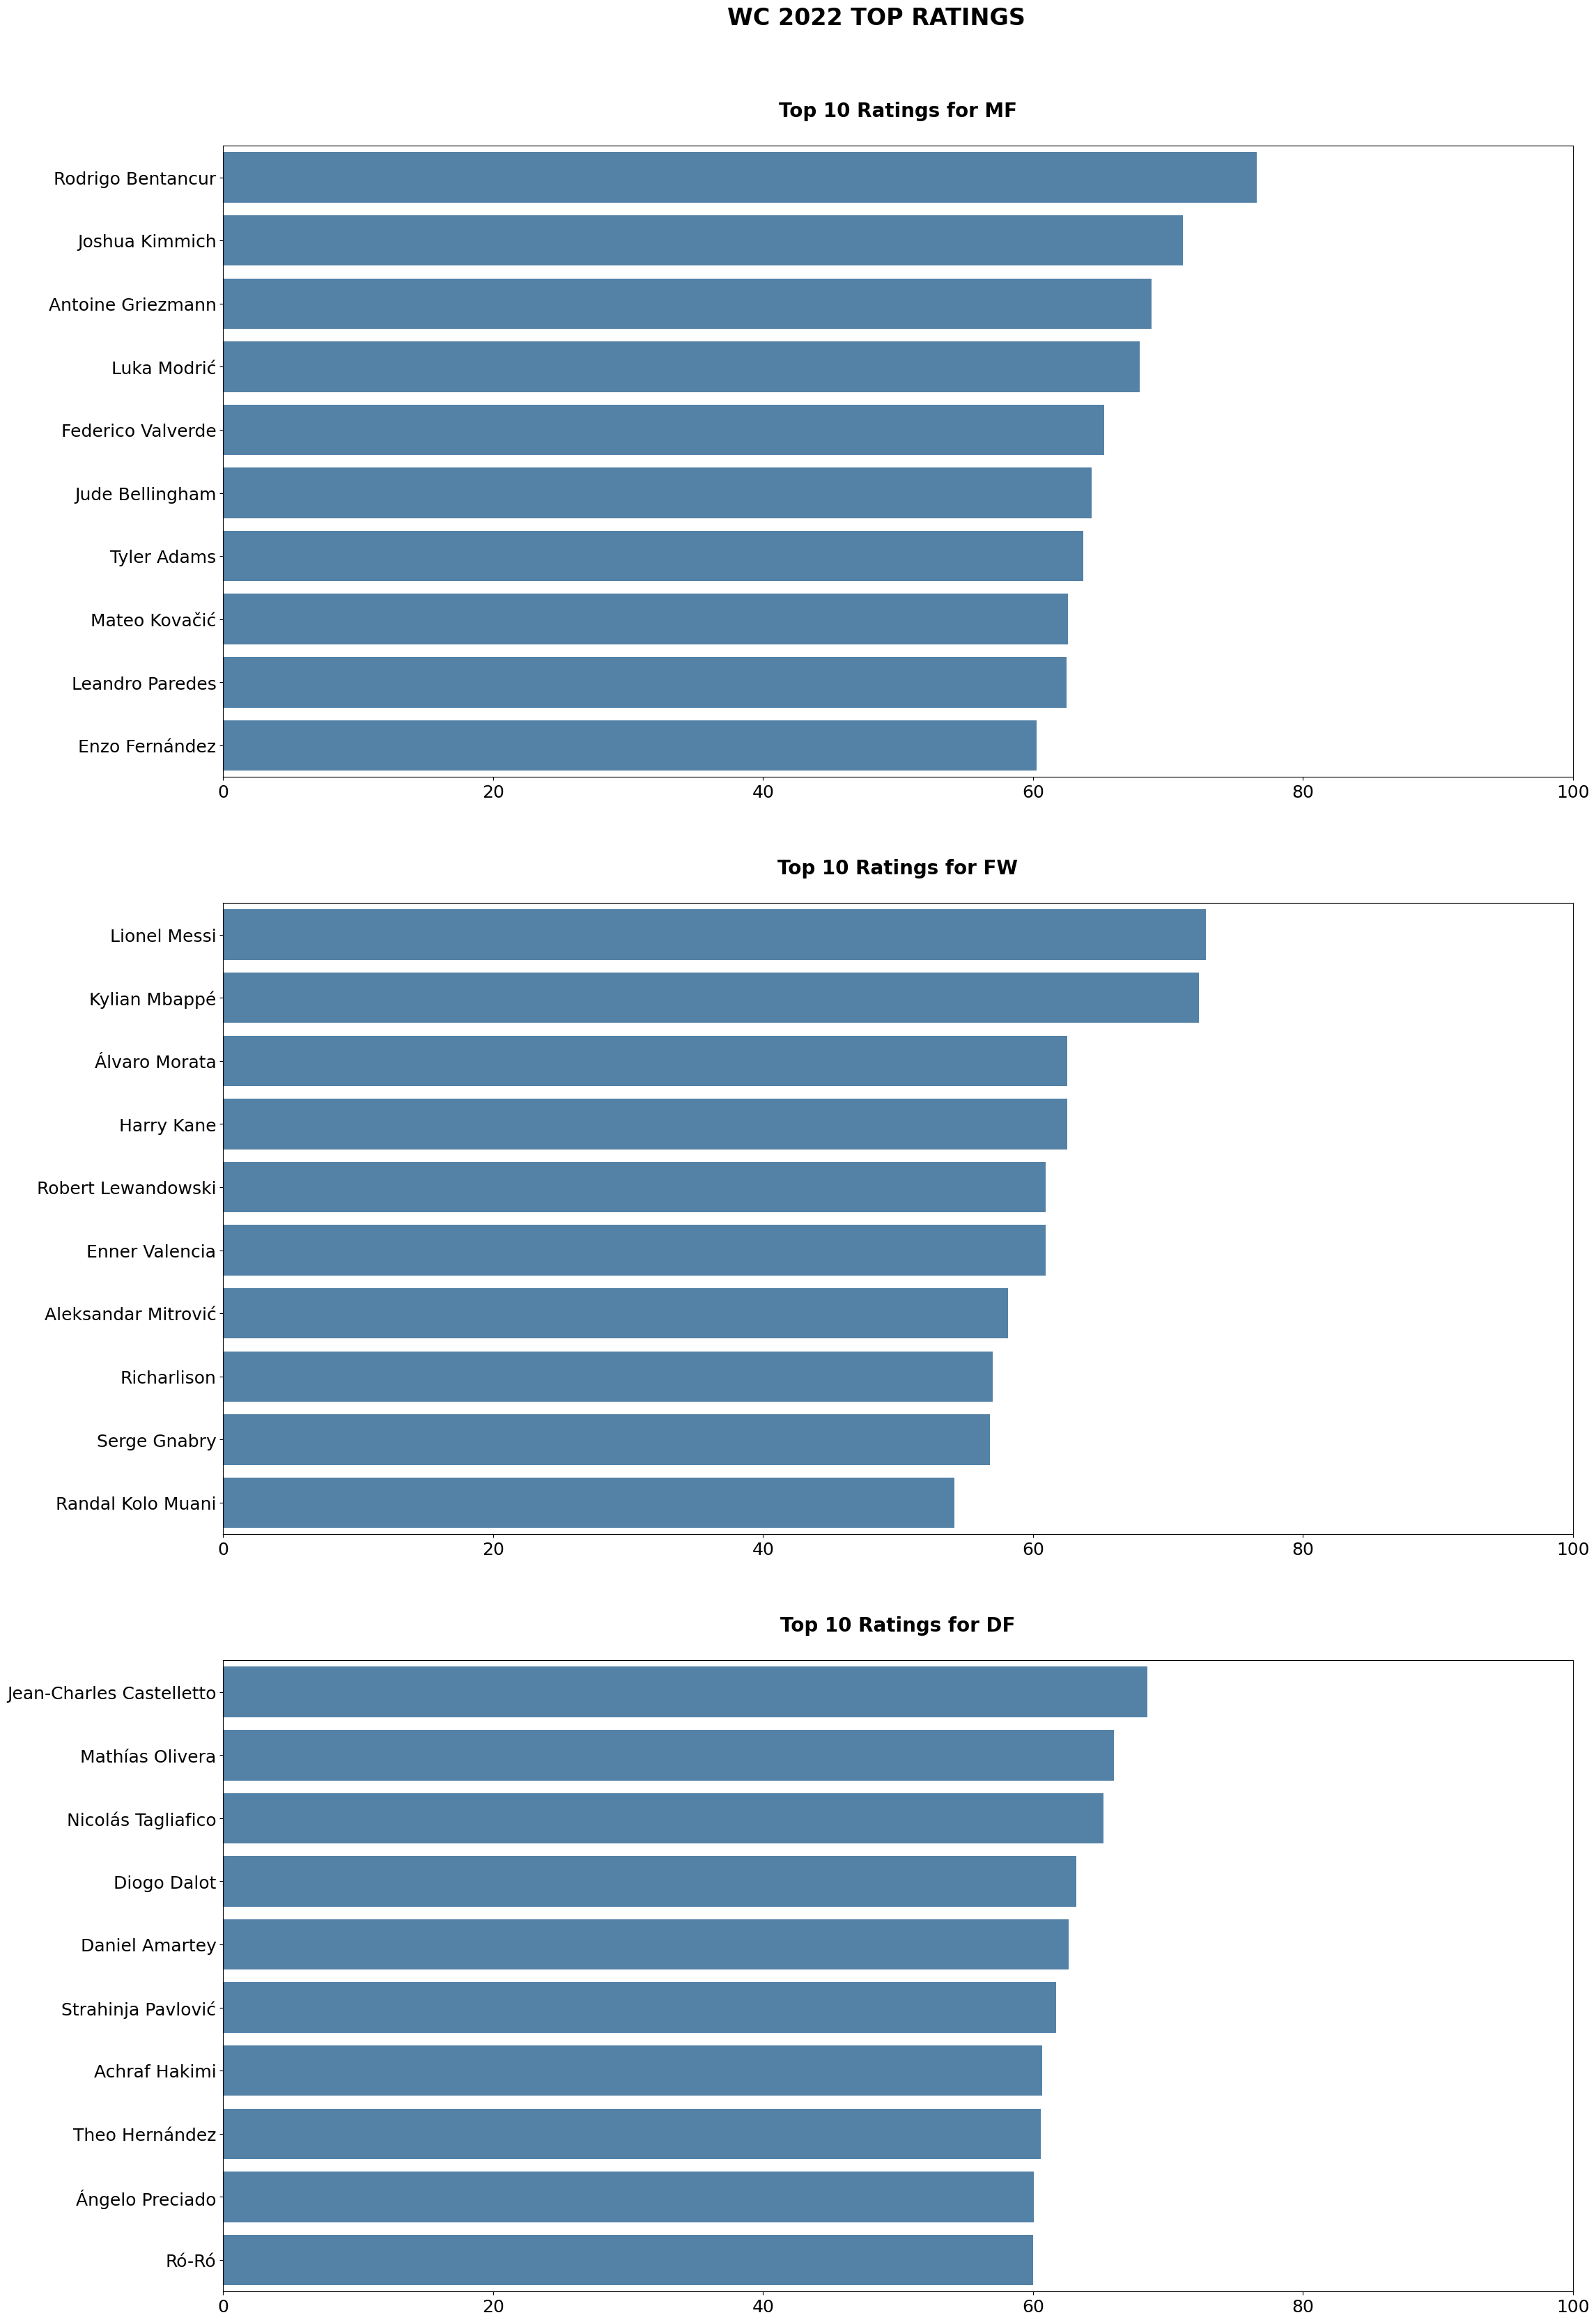

In [303]:

fig = plt.figure(figsize=(25,40))

for index,position in positions_dict.items() :
    ax = fig.add_subplot(3,1,index)
    data = X.query('position==@position').sort_values('overall_rating',ascending=False).head(10)
    sns.barplot(data = data,
                x = data.overall_rating,
                y = data.player,
                ax = ax,
               color='steelblue')
                #width = 8)
    ax.set_title(f'Top 10 Ratings for {position}',size=20,weight='bold', pad= 30)
    #ax.legend(loc='best', ncols=1)
    ax.set_ylabel('',size=24)
    ax.set_xlabel('',size=24)
    ax.get_xgridlines()
    ax.get_ygridlines()
    ax.set_xlim(right=100)
    ax.tick_params(labelsize=18)
   


fig.suptitle('WC 2022 TOP RATINGS',size=24, weight= 'bold',y=0.93)
plt.show()


## Messi vs M'Bappé

In [305]:
X2 = ratings[list(strikers.keys())].copy()
X2['player']=ratings['player']
X2= X2.query('player in ["Lionel Messi","Kylian Mbappé"]')
X2

,xg_per90,xg_assist_per90,dribbles_completed_per90,crosses_into_penalty_area_per90,goals_per_shot,player
120,91.558471,63.317053,76.306792,42.345819,46.367499,Kylian Mbappé
124,97.958544,82.592175,55.017173,1.000000,33.834585,Lionel Messi


In [285]:
ticks = [int(i) for i in np.linspace(10,100,10)]

In [287]:
ticks_labels=[str(int(i)) for i in np.linspace(10,100,10)]
ticks_labels

['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']

''

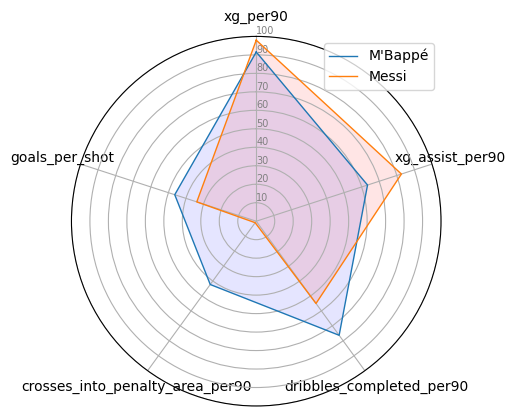

In [307]:

from math import pi
# ------- PART 1: Create background
 
# number of variable
categories=list(X2)[:-1]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(ticks, ticks_labels, color="grey", size=7)
plt.ylim(0,100)
 

values=X2.loc[120].drop('player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="M'Bappé")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=X2.loc[124].drop('player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Messi")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='best')
;